MNIST VAE
==

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import clear_output
import sys
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home='.')
print mnist.data.shape


(70000, 784)


In [9]:
def matmul(X, dout, name):
    with tf.variable_scope(name):
        _, dX = X.get_shape()
        W = tf.get_variable('W', shape=(dX, dout))
        b = tf.get_variable('b', initializer=tf.constant(np.zeros(dout).astype(np.float32)))
    return tf.matmul(X, W)+b

def assert_shape(tens, shape):
    assert tens.get_shape().is_compatible_with(shape)

def relu_layer(X, dout, name):
    return tf.nn.softplus(matmul(X, dout, name))
def tanh_layer(X, dout, name):
    return tf.nn.tanh(matmul(X, dout, name))

class VAE(object):
    def __init__(self, dX, dZ, enc_layers = (128,64), dec_layers=(64,128)):
        self.enc_layers = enc_layers
        self.dec_layers = dec_layers
        self.dZ = dZ
        self.dX = dX

        self._build_network(dX, dZ)
        self._init_tf()

    def _build_network(self, dX, dZ):

        self.X = X = tf.placeholder(tf.float32, shape=(None, dX), name='X')
        self.noise = tf.placeholder(tf.float32, shape=(None, dZ), name='Z')
        self.lr = tf.placeholder(tf.float32, shape=tuple(), name='lr')

        # Encoding
        encoding = self.X
        with tf.variable_scope('encoder'):
            for i, layer_size in enumerate(self.enc_layers):
                encoding = relu_layer(encoding, layer_size, name='enc_%d'%i)
            # make mu, sigma
            self.mu = mu_enc = matmul(encoding, dZ, name='enc_mu')
            self.log_var = log_var_enc = matmul(encoding, dZ, name='enc_sig')
        assert_shape(self.mu, [None, self.dZ])
        assert_shape(self.log_var, [None, self.dZ])

        self.var = var_enc = tf.exp(log_var_enc)
        #sigma_enc = tf.Print(sigma_enc, [sigma_enc], message='sigma_enc', summarize=20)
        #mu_enc = tf.Print(mu_enc, [mu_enc], message='mu_enc', summarize=20)

        # Decoding
        enc_output = self.noise*tf.sqrt(var_enc) + mu_enc
        assert_shape(enc_output, [None, self.dZ])
        #enc_output = tf.Print(enc_output, [enc_output], message='encoding', summarize=10)
        mu_dec = self._decode(enc_output)
        #mu_dec = tf.Print(mu_dec, [mu_dec], message='mu_dec', summarize=20)
        #X = tf.Print(self.X, [self.X], message='x', summarize=20)
        self.mu_dec = mu_dec
        assert_shape(mu_dec, [None, self.dX])
        
        # Sample decode
        self.sample_Z = tf.placeholder(tf.float32, shape=(None, dZ), name='Z_sample')
        self.sample_mu = self._decode(self.sample_Z, reuse=True)
            
        # Losses
        # KL div btwn Q(z|x) and P(z)
        #kldiv = tf.reduce_sum(self.var + tf.square(self.mu) - self.log_var, reduction_indices=[1])
        #kldiv = tf.reduce_mean(kldiv) - dZ
        
        #kldiv = tf.reduce_sum(self.var, reduction_indices=[1]) + \
        #          tf.reduce_sum(tf.square(self.mu), reduction_indices=[1]) - \
        #          tf.reduce_sum(tf.log_var, reduction_indices=[1])
        #kldiv = tf.reduce_mean(kldiv) - dZ
        # log P(x|z)
        #logpxz =  (X) * tf.log(1e-10 + mu_dec)+  \
        #          (1-X) * tf.log(1e-10 + 1 - mu_dec)
                 #-tf.reduce_sum(log_sigma_dec, reduction_indices=[1]) - \
                 #    tf.reduce_sum(tf.square(self.X - mu_dec)/sigma_dec, reduction_indices=[1])
        #logpxz = tf.reduce_mean(logpxz)
        logpxz = -tf.reduce_sum(X * tf.log(1e-6 + mu_dec) + (1-X) * tf.log(1e-6 + 1 - mu_dec), reduction_indices=1)
        kldiv = 0.5 * tf.reduce_sum(1 + log_var_enc - tf.square(mu_enc) - tf.exp(log_var_enc), reduction_indices=1)
        self.loss = tf.reduce_mean(logpxz - kldiv)
        self.stepfn = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        
    def _decode(self, output, reuse=False):
        with tf.variable_scope('decoder', reuse=reuse):
            for i, layer_size in enumerate(self.dec_layers):
                output = relu_layer(output, layer_size, name='dec_%d'%i)
            mu_dec = tf.nn.sigmoid(matmul(output, self.dX, name='dec_mu'))
        return mu_dec

    def _init_tf(self):
        self.sess = tf.Session()
        self.sess.run(tf.initialize_all_variables())

    def step(self, X, lr=0.1):
        batch_size = X.shape[0]
        z = np.random.randn(batch_size, self.dZ)
        loss, _ = self.sess.run([self.loss, self.stepfn],
                feed_dict={ self.X: X, 
                            self.noise:z,
                            self.lr: lr})
        return loss

    def encode(self, X):
        mu, sigma = self.sess.run([self.mu, self.var],
                feed_dict={ self.X: X})
        return mu, sigma
    
    def encode_decode(self, X):
        batch_size = X.shape[0]
        z = np.random.randn(batch_size, self.dZ)
        mu, mu_dec = self.sess.run([self.mu, self.mu_dec],
                          feed_dict={self.X: X, self.noise:z})
        return mu, mu_dec
    def decode(self, Z):
        mu_dec = self.sess.run(self.sample_mu, {self.sample_Z: Z})
        return mu_dec
    
    def sample(self, N):
        Z = np.random.randn(N, self.dZ)
        mu_dec = self.sess.run(self.sample_mu, {self.sample_Z: Z})
        return mu_dec
        
        
def mnist_data(batch_size, dataset=mnist.data):
    #dataset = np.array([dataset[1230], dataset[51111], dataset[30000]])
    idx = np.random.randint(low=0, high=len(dataset), size=batch_size)
    return dataset[idx,:]

def spiral_data(batch_size, spiral_rate=1.):
    T = 10
    t = np.random.uniform(size=batch_size, low=0, high=T)
    x = t*np.cos(t*spiral_rate)/T
    y = t*np.sin(t*spiral_rate)/T
    data = np.array([x,y]).T
    noise = np.random.randn(batch_size,2)/(T*2)
    return data+noise

Training & Test
===

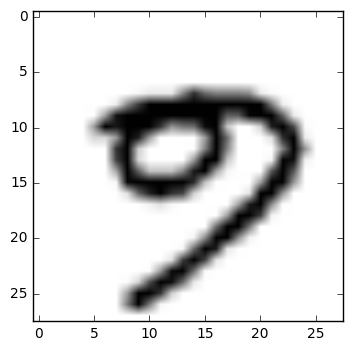

In [3]:
sample_distribution = lambda x: mnist_data(x)/255.
example = sample_distribution(1)[0]
example = np.reshape(example, [28,28])
plt.imshow(example, cmap='Greys')
plt.show()

In [10]:
#Training
tf.reset_default_graph()
np.random.seed(2)
dX = sample_distribution(1).shape[1]
dZ = 2
batch_size = 32
vae = VAE(dX, dZ, enc_layers=[512,512], dec_layers=[512,512])

tot_loss = 0
heartbeat = 500
losses = []
for i in range(6000):
    x = sample_distribution(batch_size)
    loss = vae.step(x, lr=1e-3)
    tot_loss += loss
    if i%heartbeat == 0 and i>0:
        #clear_output()
        print i, tot_loss/heartbeat
        losses.append(tot_loss/heartbeat)
        sys.stdout.flush()
        tot_loss = 0
        #mus, sigmas = vae.encode(x)
        #print np.mean(mus, axis=1)
        #print np.mean(sigmas, axis=1)

500 182.725633942
1000 168.239983887
1500 164.445025909
2000 160.809718048
2500 158.546305511
3000 157.714051086
3500 156.303582458
4000 154.68151442
4500 153.961363297
5000 152.821180237
5500 152.324248077


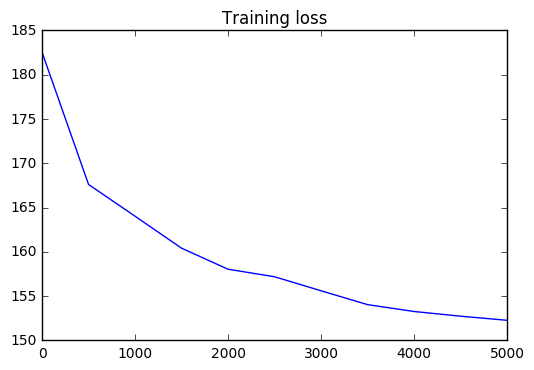

In [5]:
# Training plot
plt.title("Training loss")
plt.plot(np.arange(len(losses))*heartbeat, losses)
plt.show()

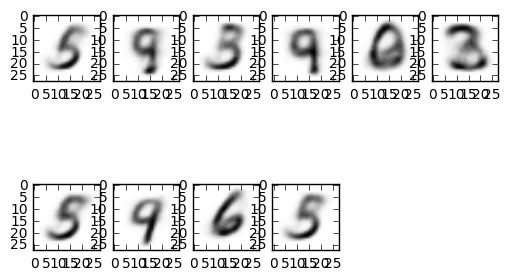

In [6]:
# Try sampling!
np.set_printoptions(suppress=True)
samples = vae.sample(10)

rows = 2
cols = len(samples)/2 +1
plt.figure()
for i, samp in enumerate(samples):
    plt.subplot(rows, cols, i+1)
    example = np.reshape(samp, [28,28])
    #print example
    plt.imshow(example, cmap='Greys')
plt.show()


[[-4.0253458  -1.00262463]]


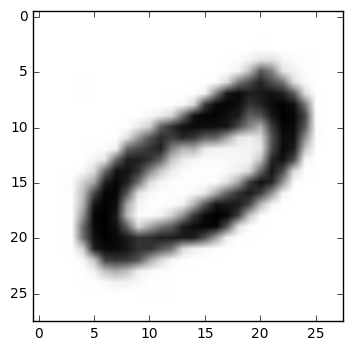

[[ 0.34039518 -0.07851452]]


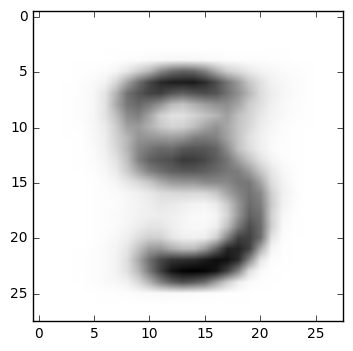

In [7]:
#encodings
imgs = [mnist.data[1230]/255., mnist.data[51111]/255.]
for img in imgs:
    encoding, decode = vae.encode_decode(np.expand_dims(img, axis=0))
    print encoding
    example = np.reshape(decode[0], [28,28])
    plt.imshow(example, cmap='Greys')
    plt.show()

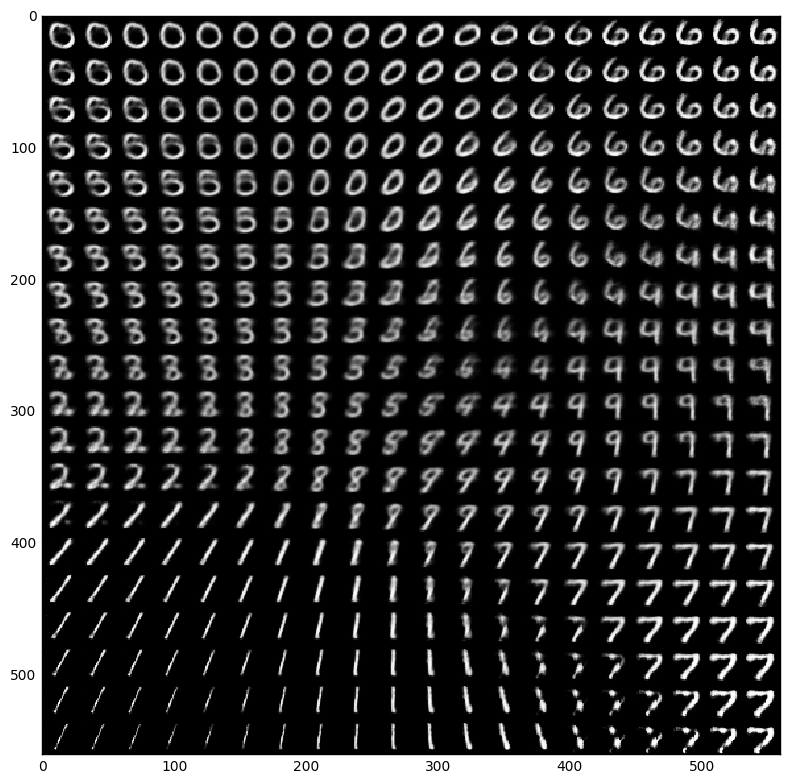

In [14]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))

for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.concatenate([np.array([xi, yi])])
        z_mu = np.expand_dims(z_mu, 0)
        x_mean = vae.decode(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()